# Time Features
# Admission/Transfer/Discharge table with Trajectories

We want to look into the cases that have a large difference between the time0 predictions and time24 predictions.


We'll look at: the complete `1_4_cohort` here

- pat services
- pat lv of care
- patient trajectories from admission until 24hrs

Subgroups of the entire cohort will be analyzed in another notebook

In [236]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [237]:
# adjust this to hide ID columns for posting to github
forrepo=True

hidecols = []
if forrepo:
    hidecols=['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'] # these are hidden columns

In [238]:
# view data frame

# adjust this to hide ID columns for posting to github
# forrepo=False
forrepo=True
def view_df(df):
    hidecols = []
    if forrepo:
        hidecols=['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded'] # these are hidden columns
        
    return(df.drop(hidecols, axis=1, errors='ignore').head(3))

Pulled adt table from sch_core_2021 for the 6_7 cohort using the following SQL:

```select * 
    from `som-nero-phi-jonc101.shc_core_2021.adt` as adt
    where adt.pat_enc_csn_id_coded 
    in (
        select pat_enc_csn_id_coded from 
            `som-nero-phi-jonc101.triageTD.6_7_cohort4`
    )```

# Data

Load in the data

In [283]:
# read in data files
datadir = "../../DataTD/shc2021/"
outdir = "../../OutputTD/shc2021/"

adt_file = datadir + "cohort3_adt_2021.csv"  # used cohort3
cohort_file = outdir + "7_cohort4_3hr_labels_noOR.csv"

adt = pd.read_csv(adt_file)
cohort = pd.read_csv(cohort_file)

In [284]:
# just checking the cohorts
csns = cohort.pat_enc_csn_id_coded.unique()
adt_csns = adt.pat_enc_csn_id_coded.unique()

print("cohort csns: {}".format(len(csns)))
print("adt csns: {}".format(len(adt_csns)))

adt = adt[adt.pat_enc_csn_id_coded.isin(cohort.pat_enc_csn_id_coded)]
print(adt.shape)
print(adt.pat_enc_csn_id_coded.nunique())

cohort csns: 52532
adt csns: 61176
(982628, 11)
52532


In [285]:
adt.effective_time_jittered_utc = pd.to_datetime(adt.effective_time_jittered_utc)
cohort.admit_time = pd.to_datetime(cohort.admit_time, utc=True)
# los.admit_time = pd.to_datetime(los.admit_time)
# los.first_ed_time = pd.to_datetime(los.first_ed_time)

In [286]:
adt.dtypes

anon_id                                     object
pat_enc_csn_id_coded                         int64
effective_time_jittered_utc    datetime64[ns, UTC]
seq_num_in_enc                               int64
pat_class                                   object
base_pat_class_c                           float64
pat_lvl_of_care_c                          float64
pat_lv_of_care                              object
event_type                                  object
pat_service                                 object
department_id                              float64
dtype: object

In [287]:
cohort.dtypes.head()

anon_id                              object
pat_enc_csn_id_coded                  int64
admit_time              datetime64[ns, UTC]
label_max3                            int64
label_3hr_recent                      int64
dtype: object

# Bring in the ADT Table

We can use the ADT table to look at 

- pat_class
- pat_lv_of_care

In [307]:
# add year of admit
adt['effective_year'] = pd.DatetimeIndex(adt['effective_time_jittered_utc']).year

# add the admit time column from the cohort to adt table
admit_time = cohort[['anon_id', 'pat_enc_csn_id_coded', 'admit_time']]
adt_admit = admit_time.merge(adt, how='left') # Minh- switched position of admit_time and adt to keep admit_time at the beginning
# adt_admit = adt_los.drop(['admit_time'], axis=1).merge(admit_time, how='left', on=['pat_enc_csn_id_coded'])

# do we still have all of the CSNs? - YES
print(adt_admit.pat_enc_csn_id_coded.nunique())
print(adt_admit.shape)

adt_admit.columns

52532
(982628, 13)


Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year'],
      dtype='object')

In [289]:
adt_admit.dtypes

anon_id                                     object
pat_enc_csn_id_coded                         int64
admit_time                     datetime64[ns, UTC]
effective_time_jittered_utc    datetime64[ns, UTC]
seq_num_in_enc                               int64
pat_class                                   object
base_pat_class_c                           float64
pat_lvl_of_care_c                          float64
pat_lv_of_care                              object
event_type                                  object
pat_service                                 object
department_id                              float64
effective_year                               int64
dtype: object

# Time before/since admit
- Time before admit = door-to-dispo: time from entering ED to inpatient admission
- Time since admit = inpatient length of stay: time from inpatient admission to discharge/death

We want to find the length of stay in the ED (door-to-dispo time), so we'll add some columns to help figure out which ADT events mark the admission to Emergency services and transfer to Inpatient.

We're looking for:

- the first Inpatient event that follow Emergency Services (should be admit time)
- the first Emergency Services event

In [308]:
# this takes a bit of time

# compute the time before admit for each of these events
adt_admit['time_before_admit'] = adt_admit.apply(lambda x: x.admit_time - x.effective_time_jittered_utc, axis=1)

# compute the time since admit for each of these events
adt_admit['time_since_admit'] = adt_admit.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)

print(adt_admit.pat_enc_csn_id_coded.nunique())
print(adt_admit.shape)

52532
(982628, 15)


In [291]:
adt_admit.dtypes

anon_id                                     object
pat_enc_csn_id_coded                         int64
admit_time                     datetime64[ns, UTC]
effective_time_jittered_utc    datetime64[ns, UTC]
seq_num_in_enc                               int64
pat_class                                   object
base_pat_class_c                           float64
pat_lvl_of_care_c                          float64
pat_lv_of_care                              object
event_type                                  object
pat_service                                 object
department_id                              float64
effective_year                               int64
time_before_admit                  timedelta64[ns]
time_since_admit                   timedelta64[ns]
dtype: object

In [292]:
# adt_admit.head(3)
# adt_admit.drop(hidecols, axis=1, errors='ignore').head(3)
view_df(adt_admit)

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit
0,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00,5,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,2015,0 days 01:21:00,-1 days +22:39:00
1,2015-01-28 00:46:00+00:00,2015-01-27 07:59:00+00:00,2,Emergency Services,NaN,NaN,NaN,Census,Emergency,2001002.0,2015,0 days 16:47:00,-1 days +07:13:00
2,2015-01-28 00:46:00+00:00,2015-01-27 23:25:00+00:00,6,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,2001002.0,2015,0 days 01:21:00,-1 days +22:39:00


In [309]:
# mark the events with some labels that make things easier later

# sort by csn and time
# adt_admit.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)
adt_admit = adt_admit.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc']) # do this if note use inplace=True

# **assumes dataframe is sorted by time

# the first inpatient event following Emergency Services must meet these three criteria:
    # mark whether previous entry had pat class Emergency Services
adt_admit['prev_emerg'] = adt_admit.pat_class.shift() == 'Emergency Services'
    # mark whether current event has pat class Inpatient
adt_admit['curr_inpatient'] = adt_admit.pat_class == 'Inpatient'
    # mark whether current event is continued csn as previous
adt_admit['continued'] = adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift())

# find our cases by taking the AND of these columns
cols = ['prev_emerg', 'curr_inpatient', 'continued']
adt_admit['first_ip'] = adt_admit[cols].all(axis=1)

print(adt_admit.pat_enc_csn_id_coded.nunique())
print(adt_admit.shape)
# adt_admit.drop(hidecols, axis=1, errors='ignore').head()

52532
(982628, 19)


In [294]:
view_df(adt_admit)

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
46580,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2015,0 days 09:08:00,-1 days +14:52:00,False,False,False,False
46581,2015-01-02 03:48:00+00:00,2015-01-02 03:09:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,2015,0 days 00:39:00,-1 days +23:21:00,True,False,True,False
46579,2015-01-02 03:48:00+00:00,2015-01-02 03:09:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,2001002.0,2015,0 days 00:39:00,-1 days +23:21:00,True,False,True,False


### Checking events for door-to-dispo time, approach #1

In [31]:
# start by taking events that have a different pat class from the next event (below it)
change_pat = adt_admit[~adt_admit.pat_class.eq(adt_admit.pat_class.shift())]
print(change_pat.pat_enc_csn_id_coded.nunique())
print(change_pat.shape)
# change_pat.drop(hidecols, axis=1, errors='ignore').head()

52532
(107028, 19)


In [32]:
# lots of these still have many events - meaning they moved around a lot
change_pat.groupby('pat_enc_csn_id_coded').anon_id.count().value_counts()

2    51091
3      955
4      448
5       31
6        4
1        2
8        1
Name: anon_id, dtype: int64

In [33]:
# keep the event with pat_class == Emergency Services, that occurs before the first inpatient event
# check to make sure that we're looking at the same CSN between both events
# don't take any where admit ocurred before ER event - happens when people move around a lot (ER -> Inpatient -> ER -> Inpatient)
keep_visits = change_pat[(change_pat.pat_class == 'Emergency Services') & 
                         (change_pat.shift(-1).first_ip) &
                         (change_pat.shift(-1).pat_enc_csn_id_coded == change_pat.pat_enc_csn_id_coded) & 
                         (change_pat.time_before_admit >= timedelta(days=0))] # remove this for now # ??? same results with this set

print(keep_visits.pat_enc_csn_id_coded.nunique())
print(keep_visits.shape)
# keep_visits.drop(hidecols, axis=1, errors='ignore').head()

52530
(52530, 19)


In [34]:
# look at the number of csn's that were dropped becuase admit time was before first ER event
print(change_pat.pat_enc_csn_id_coded.nunique())
print(keep_visits.pat_enc_csn_id_coded.nunique())

# we lose csns where admit occurs before the first ER - lost 2??? ---? check these out

52532
52530


In [35]:
# check to see if all of the remaining rows are with seq=1
print(keep_visits.seq_num_in_enc.describe())
keep_visits[keep_visits['seq_num_in_enc'] > 1]

count    52530.000000
mean         1.000038
std          0.008726
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: seq_num_in_enc, dtype: float64


,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
338797,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 09:26:00+00:00,3,Emergency Services,3.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Emergency,2001002.0,2018,0 days 15:14:00,-1 days +08:46:00,False,False,True,False


In [36]:
# no one has admit_time before ED, quickest admit
keep_visits.sort_values('time_before_admit').head(1)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
589331,JC2812249,131277235724,2019-10-22 00:03:00+00:00,2019-10-22 00:02:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2019,0 days 00:01:00,-1 days +23:59:00,False,False,False,False


In [37]:
# no one has admit_time before ED, latest admit
keep_visits.sort_values('time_before_admit').tail(1)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
299830,JC1840822,131090609481,2015-07-10 18:48:00+00:00,2015-07-02 20:22:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2015,7 days 22:26:00,-8 days +01:34:00,False,False,False,False


In [38]:
# check the first patient who was admitted 1 min after presenting in ED
adt_admit[adt_admit['pat_enc_csn_id_coded'] == 131277235724].head(2)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
589331,JC2812249,131277235724,2019-10-22 00:03:00+00:00,2019-10-22 00:02:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2019,0 days 00:01:00,-1 days +23:59:00,False,False,False,False
589330,JC2812249,131277235724,2019-10-22 00:03:00+00:00,2019-10-22 00:03:00+00:00,2,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Emergency,2001002.0,2019,0 days 00:00:00,0 days 00:00:00,True,True,True,True


In [39]:
# the only case with seq > 1 and it happned that patient was under obs before moved to emergency, 
# also pat_service is indication rather than pat_class
adt_admit[adt_admit['pat_enc_csn_id_coded'] == 131246488352].head(10)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
338799,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 00:01:00+00:00,1,Observation,2.0,NaN,NaN,Admission,Emergency,2001002.0,2018,1 days 00:39:00,-2 days +23:21:00,False,False,False,False
338798,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 07:59:00+00:00,2,Observation,NaN,NaN,NaN,Census,Emergency,2001002.0,2018,0 days 16:41:00,-1 days +07:19:00,False,False,True,False
338797,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 09:26:00+00:00,3,Emergency Services,3.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Emergency,2001002.0,2018,0 days 15:14:00,-1 days +08:46:00,False,False,True,False
338794,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 10:28:00+00:00,4,Emergency Services,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer Out,Emergency,2001002.0,2018,0 days 14:12:00,-1 days +09:48:00,True,False,True,False
338801,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 10:28:00+00:00,5,Emergency Services,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Emergency,2001002.0,2018,0 days 14:12:00,-1 days +09:48:00,True,False,True,False
338796,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-02 10:51:00+00:00,6,Emergency Services,NaN,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Emergency,2001002.0,2018,0 days 13:49:00,-1 days +10:11:00,True,False,True,False
338793,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-03 00:36:00+00:00,7,Emergency Services,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer Out,Emergency,2001002.0,2018,0 days 00:04:00,-1 days +23:56:00,True,False,True,False
338795,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-03 00:36:00+00:00,8,Emergency Services,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Emergency,2001002.0,2018,0 days 00:04:00,-1 days +23:56:00,True,False,True,False
338800,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-03 00:40:00+00:00,9,Emergency Services,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer Out,Emergency,2001002.0,2018,0 days 00:00:00,0 days 00:00:00,True,False,True,False
338816,JC1926085,131246488352,2018-02-03 00:40:00+00:00,2018-02-03 00:40:00+00:00,10,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,General Medicine (University),2000237.0,2018,0 days 00:00:00,0 days 00:00:00,True,True,True,True


In [40]:
# 2 CSNs in keep_visits but not in change_pat 
change_pat[~change_pat['pat_enc_csn_id_coded'].isin(keep_visits['pat_enc_csn_id_coded'])]

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
46488,JC1169632,131127789342,2015-10-31 05:38:00+00:00,2015-10-31 05:38:00+00:00,4,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Neurosurgery,2001002.0,2015,0 days,0 days,True,True,True,True
340345,JC1928643,131164384313,2015-12-28 21:41:00+00:00,2015-12-28 21:41:00+00:00,2,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Orthopaedic Surgery,2001002.0,2015,0 days,0 days,True,True,True,True


In [41]:
# a correct case
adt_admit[adt_admit['pat_enc_csn_id_coded'] == 131062572931].sort_values('seq_num_in_enc').head()

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
46580,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2015,0 days 09:08:00,-1 days +14:52:00,False,False,False,False
46581,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-02 03:09:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,2015,0 days 00:39:00,-1 days +23:21:00,True,False,True,False
46579,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-02 03:09:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,2001002.0,2015,0 days 00:39:00,-1 days +23:21:00,True,False,True,False
46578,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,4,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,2015,0 days 00:00:00,0 days 00:00:00,True,False,True,False
46582,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),2000237.0,2015,0 days 00:00:00,0 days 00:00:00,True,True,True,True


In [42]:
# one of the 2 cases that were removed
# change_pat[change_pat['pat_enc_csn_id_coded'] == 131127789342].sort_values('seq_num_in_enc')
adt_admit[adt_admit['pat_enc_csn_id_coded'] == 131127789342].sort_values('seq_num_in_enc').head(4)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
46482,JC1169632,131127789342,2015-10-31 05:38:00+00:00,2015-10-31 04:06:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2015,0 days 01:32:00,-1 days +22:28:00,True,False,False,False
46481,JC1169632,131127789342,2015-10-31 05:38:00+00:00,2015-10-31 04:06:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,2015,0 days 01:32:00,-1 days +22:28:00,True,False,True,False
46480,JC1169632,131127789342,2015-10-31 05:38:00+00:00,2015-10-31 04:06:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,2001002.0,2015,0 days 01:32:00,-1 days +22:28:00,True,False,True,False
46488,JC1169632,131127789342,2015-10-31 05:38:00+00:00,2015-10-31 05:38:00+00:00,4,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Neurosurgery,2001002.0,2015,0 days 00:00:00,0 days 00:00:00,True,True,True,True


In [43]:
change_pat[change_pat['pat_enc_csn_id_coded'] == 131127789342].sort_values('seq_num_in_enc').head(4)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
46488,JC1169632,131127789342,2015-10-31 05:38:00+00:00,2015-10-31 05:38:00+00:00,4,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Neurosurgery,2001002.0,2015,0 days,0 days,True,True,True,True


In [44]:
# one of the 2 cases that were removed
adt_admit[adt_admit['pat_enc_csn_id_coded'] == 131164384313].sort_values('seq_num_in_enc').head(3)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
340341,JC1928643,131164384313,2015-12-28 21:41:00+00:00,2015-12-28 17:49:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2015,0 days 03:52:00,-1 days +20:08:00,True,False,False,False
340345,JC1928643,131164384313,2015-12-28 21:41:00+00:00,2015-12-28 21:41:00+00:00,2,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Patient Update,Orthopaedic Surgery,2001002.0,2015,0 days 00:00:00,0 days 00:00:00,True,True,True,True
340359,JC1928643,131164384313,2015-12-28 21:41:00+00:00,2015-12-29 00:03:00+00:00,3,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer Out,Orthopaedic Surgery,2001002.0,2015,-1 days +21:38:00,0 days 02:22:00,False,True,True,False


In [45]:
change_pat[change_pat['pat_enc_csn_id_coded'] == 131062572931].sort_values('seq_num_in_enc').head(4)

,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
46580,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,2015,0 days 09:08:00,-1 days +14:52:00,False,False,False,False
46582,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),2000237.0,2015,0 days 00:00:00,0 days 00:00:00,True,True,True,True


### Use this to get door-to-dispo time
- Effective time of seq_num_in_enc=1 to admit_time

In [16]:
# by pass change_pat since the above 2 cases were drop at the change_pat = adt_admit.... and then keep_visits = change_pat...
keep_visits2 = adt_admit[(adt_admit.seq_num_in_enc == 1)]

print(keep_visits2.pat_enc_csn_id_coded.nunique())
print(keep_visits2.shape)
# keep_visits2.drop(hidecols, axis=1, errors='ignore').head()

52532
(52532, 19)


### continue here keep_visits vs keep_visits2

In [47]:
# compute the time lapse between the ER visit and admission in hours
keep_visits['hours_before_admit'] = round(keep_visits.time_before_admit / np.timedelta64(1, 'h'), 2)
# keep_visits.drop(hidecols, axis=1, errors='ignore').head(1)

<ipython-input-47-dce2b75d2973>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_visits['hours_before_admit'] = round(keep_visits.time_before_admit / np.timedelta64(1, 'h'), 2)


In [49]:
# print(keep_visits.columns) # note this only has 52530 unique csns, which is 2 less
print(keep_visits.hours_before_admit.describe())
# keep_visits['hours_before_admit_quantile'] = pd.qcut(keep_visits.hours_before_admit, 10) # not working

count    52530.000000
mean         4.810179
std          6.415204
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_before_admit, dtype: float64


In [17]:
# compute the time lapse between the ER visit and admission in hours
keep_visits2['hours_before_admit'] = round(keep_visits2.time_before_admit / np.timedelta64(1, 'h'), 2)
# keep_visits2.drop(hidecols, axis=1, errors='ignore').head(1)

<ipython-input-17-0c1f23210423>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep_visits2['hours_before_admit'] = round(keep_visits2.time_before_admit / np.timedelta64(1, 'h'), 2)


In [18]:
# print(keep_visits2.columns) # note this has the correct number of 52530 unique csns
# didn't change the summary stats
print(keep_visits2.hours_before_admit.describe())
# keep_visits2['hours_before_admit_quantile'] = pd.qcut(keep_visits2.hours_before_admit, 10) # not working

count    52532.000000
mean         4.810278
std          6.415523
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_before_admit, dtype: float64


In [19]:
keep_visits2.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip', 'hours_before_admit'],
      dtype='object')

### Use the correct keep_visits2, hours_in_ed = door-to-dispo time
Should have the same number of unique CSNs as the cohort

In [20]:
# save the hours before 
# final_visits = keep_visits[['pat_enc_csn_id_coded', 'hours_before_admit']]
edtime = keep_visits2[['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
                            'effective_time_jittered_utc', 'time_before_admit', 'hours_before_admit']]

edtime.rename({'hours_before_admit': 'hours_in_ed', 'effective_time_jittered_utc': 'first_ed_time'}, axis=1, inplace=True)

print(edtime.shape)
print(edtime.pat_enc_csn_id_coded.nunique())

edtime.columns
# final_visits.drop(hidecols, axis=1, errors='ignore').head()

(52532, 6)
52532


C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'time_before_admit', 'hours_in_ed'],
      dtype='object')

## Approach #2

In [311]:
adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip'],
      dtype='object')

In [319]:
# add a couple more columns

# get time of first emergency services event
first_ED = adt_admit[(adt_admit.pat_class == 'Emergency Services')].sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc']).groupby('pat_enc_csn_id_coded').first().reset_index()

print(adt_admit.pat_enc_csn_id_coded.nunique())
print(first_ED.pat_enc_csn_id_coded.nunique())

set(adt_admit.pat_enc_csn_id_coded) - set(first_ED.pat_enc_csn_id_coded)

print("\n", first_ED.pat_service.value_counts())
print("\n", first_ED.event_type.value_counts())

first_ED['first_ed_time'] = first_ED.effective_time_jittered_utc
first_ED_time = first_ED[['pat_enc_csn_id_coded', 'first_ed_time']].drop_duplicates()

adt_ed = adt_admit.merge(first_ED_time, how='left')
adt_ed.shape

edtime = adt_ed[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time']].drop_duplicates()
edtime['hours_in_ed'] = round(edtime.apply(lambda x: x.admit_time - x.first_ed_time, axis=1)/ np.timedelta64(1, 'h'), 2)

print(edtime.shape)
print(edtime.pat_enc_csn_id_coded.nunique())
edtime.columns

52532
52532

 Emergency                        52519
Emergency Medicine                   7
General Medicine (University)        2
Gynecology                           1
General Medicine (PAMF)              1
Hepatology                           1
Psychiatry                           1
Name: pat_service, dtype: int64

 Admission         52531
Patient Update        1
Name: event_type, dtype: int64
(52532, 5)
52532


Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed'],
      dtype='object')

In [320]:
# print(keep_visits2.columns) # note this has the correct number of 52530 unique csns
# didn't change the summary stats
print(edtime.hours_in_ed.describe())

count    52532.000000
mean         4.810099
std          6.415100
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_in_ed, dtype: float64


In [321]:
cohort4_3hr_noOR_first_ed_time = edtime[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time']]
cohort4_3hr_noOR_first_ed_time.head()
print(cohort4_3hr_noOR_first_ed_time.shape)
print(cohort4_3hr_noOR_first_ed_time.anon_id.nunique())

(52532, 4)
35144


In [322]:
savefile = outdir + "/9_door_to_dispo_time.csv"
edtime.to_csv(savefile, index=False)

savefile = outdir + "/9_cohort4_3hr_noOR_first_ed_time.csv"
cohort4_3hr_noOR_first_ed_time.to_csv(savefile, index=False)

# Look at inpatient pat services - PAT_SERVICE trajectory

In [323]:
first_ips = adt_admit[adt_admit.first_ip == True]

print(first_ips.shape)
print(first_ips.pat_enc_csn_id_coded.nunique())

(52559, 19)
52532


In [324]:
# find first inpatient pat service for each csn
first_ip_pat_service = first_ips[['pat_enc_csn_id_coded', 'pat_service']].drop_duplicates()

print(first_ip_pat_service.shape)
print(first_ip_pat_service.pat_enc_csn_id_coded.nunique())

(52538, 2)
52532


# multiple emergency-->inpatient changes

Some CSNs have multiple emergency-->inpatient changes. This means they went from emergency-->inpatient-->emergency-->inpatient.

Take a look at some of these. The first change from emergency-->inpatient would be the admit time. Keep this occurrence. This only happen for 10 CSNs.

In [325]:
counts = first_ip_pat_service.groupby('pat_enc_csn_id_coded').count().sort_values('pat_service')

multi_csns = counts[counts.pat_service > 1]

print(multi_csns.shape)
multi_csns

(6, 1)


,pat_service
pat_enc_csn_id_coded,
131230902129,2
131201950621,2
131164129413,2
131230527582,2
131176788268,2
131244958373,2


In [326]:
adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip'],
      dtype='object')

In [327]:
adt_admit[adt_admit.pat_enc_csn_id_coded == 131230902129].sort_values('seq_num_in_enc')[
    ['anon_id', 'pat_enc_csn_id_coded', 'effective_time_jittered_utc', 'admit_time',
       'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c',
       'pat_lv_of_care', 'event_type', 'pat_service'
       ]]

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,admit_time,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
351922,JC1947533,131230902129,2017-05-02 19:17:00+00:00,2017-05-02 20:14:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency
351919,JC1947533,131230902129,2017-05-02 20:14:00+00:00,2017-05-02 20:14:00+00:00,2,Inpatient,1.0,9.0,IICU/Intermediate Care (Assessment or interven...,Patient Update,Emergency
351923,JC1947533,131230902129,2017-05-02 21:57:00+00:00,2017-05-02 20:14:00+00:00,3,Emergency Services,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Transfer Out,Emergency
351920,JC1947533,131230902129,2017-05-02 21:57:00+00:00,2017-05-02 20:14:00+00:00,4,Emergency Services,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Transfer In,Emergency
351921,JC1947533,131230902129,2017-05-02 22:40:00+00:00,2017-05-02 20:14:00+00:00,5,Emergency Services,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Transfer Out,Emergency
351924,JC1947533,131230902129,2017-05-02 22:40:00+00:00,2017-05-02 20:14:00+00:00,6,Inpatient,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Transfer In,Cardiology
351926,JC1947533,131230902129,2017-05-03 06:59:00+00:00,2017-05-02 20:14:00+00:00,7,Inpatient,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Census,Cardiology
351925,JC1947533,131230902129,2017-05-04 06:59:00+00:00,2017-05-02 20:14:00+00:00,8,Inpatient,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Census,Cardiology
351927,JC1947533,131230902129,2017-05-04 22:30:00+00:00,2017-05-02 20:14:00+00:00,9,Inpatient,NaN,9.0,IICU/Intermediate Care (Assessment or interven...,Discharge,Cardiology Transplant


In [328]:
# keep the first occurrence of inpatient event
first_ips_keep = first_ips.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc']).groupby('pat_enc_csn_id_coded').first().reset_index()

# now we have one event per person
print(first_ips_keep.pat_enc_csn_id_coded.nunique())
print(first_ips_keep.shape)

52532
(52532, 19)


In [329]:
view_df(first_ips_keep)

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,effective_year,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip
0,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),2000237.0,2015,0 days,0 days,True,True,True,True
1,2015-01-02 05:53:00+00:00,2015-01-02 05:53:00+00:00,9,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,2000250.0,2015,0 days,0 days,True,True,True,True
2,2015-01-05 03:20:00+00:00,2015-01-05 03:20:00+00:00,7,Inpatient,1.0,8.0,Critical Care,Transfer In,Critical Care,2000262.0,2015,0 days,0 days,True,True,True,True


In [330]:
print(first_ips_keep.columns)
print(edtime.columns)

Index(['pat_enc_csn_id_coded', 'anon_id', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip'],
      dtype='object')
Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed'],
      dtype='object')


In [331]:
first_ips_save = first_ips_keep[['pat_enc_csn_id_coded', 'anon_id', 
                                 'time_since_admit','effective_time_jittered_utc',
                                 'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c',
                                 'pat_lv_of_care', 'event_type', 'pat_service']]

# Minh added this to include the new columns in final_visits
# first_ips_save = final_visits.merge(first_ips_save, how='left')

print(first_ips_save.pat_enc_csn_id_coded.nunique())
print(first_ips_save.shape)
print(first_ips_save.columns)
view_df(first_ips_save)

52532
(52532, 11)
Index(['pat_enc_csn_id_coded', 'anon_id', 'time_since_admit',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service'],
      dtype='object')


,time_since_admit,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,0 days,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University)
1,0 days,2015-01-02 05:53:00+00:00,9,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery
2,0 days,2015-01-05 03:20:00+00:00,7,Inpatient,1.0,8.0,Critical Care,Transfer In,Critical Care


## Look at last Emergeny Services Pat Service

In [332]:
# mark the events with some labels that make things easier later

# **assumes dataframe is sorted by time

# mark whether next entry is inpatient
adt_admit['next_ip'] = adt_admit.pat_class.shift(-1) == 'Inpatient'
# mark whether current event has pat class Inpatient
adt_admit['curr_emerg'] = adt_admit.pat_class == 'Emergency Services'
# mark whether current event is continued csn as previous
adt_admit['not_continued'] = ~adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift(-1))

# find our cases by taking the AND of these columns
cols = ['next_ip', 'curr_emerg', 'continued']
adt_admit['last_emerg'] = adt_admit.curr_emerg & (adt_admit.next_ip | adt_admit.not_continued) 

adt_admit[['pat_enc_csn_id_coded', 'pat_class', 'last_emerg'] + cols].head(20)

,pat_enc_csn_id_coded,pat_class,last_emerg,next_ip,curr_emerg,continued
46580,131062572931,Emergency Services,False,False,True,False
46581,131062572931,Emergency Services,False,False,True,True
46579,131062572931,Emergency Services,False,False,True,True
46578,131062572931,Emergency Services,True,True,True,True
46582,131062572931,Inpatient,False,True,False,True
46583,131062572931,Inpatient,False,True,False,True
46584,131062572931,Inpatient,False,True,False,True
46585,131062572931,Inpatient,False,True,False,True
46586,131062572931,Inpatient,False,False,False,True
959876,131062745090,Emergency Services,False,False,True,False


In [333]:
last_emergs = adt_admit[adt_admit.last_emerg == True]

# take the first one for each csn
last_emergs_keep = last_emergs.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc']).groupby('pat_enc_csn_id_coded').first().reset_index()

# now we have one event per person
print(last_emergs_keep.pat_enc_csn_id_coded.nunique())
print(last_emergs_keep.shape)

view_df(last_emergs)

52532
(52532, 23)


,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,...,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
46578,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,4,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,...,0 days,0 days,True,False,True,False,True,True,False,True
959883,2015-01-02 05:53:00+00:00,2015-01-02 05:53:00+00:00,8,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,...,0 days,0 days,True,False,True,False,True,True,False,True
720865,2015-01-05 03:20:00+00:00,2015-01-05 03:20:00+00:00,6,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,...,0 days,0 days,True,False,True,False,True,True,False,True


In [334]:
print(last_emergs_keep.columns)
print(edtime.columns)

Index(['pat_enc_csn_id_coded', 'anon_id', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip', 'next_ip', 'curr_emerg', 'not_continued', 'last_emerg'],
      dtype='object')
Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed'],
      dtype='object')


In [335]:
last_emerg_save = last_emergs_keep[['pat_enc_csn_id_coded', 'anon_id', 
                                 'time_since_admit', 'effective_time_jittered_utc',
                                 'seq_num_in_enc', 'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c',
                                 'pat_lv_of_care', 'event_type', 'pat_service']]

# Minh added this to include the new columns in final_visits
# last_emerg_save = final_visits.merge(last_emerg_save, how='left')

print(last_emerg_save.pat_enc_csn_id_coded.nunique())
print(last_emerg_save.shape)
print(last_emerg_save.columns)
view_df(last_emerg_save)

52532
(52532, 11)
Index(['pat_enc_csn_id_coded', 'anon_id', 'time_since_admit',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service'],
      dtype='object')


,time_since_admit,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,0 days,2015-01-02 03:48:00+00:00,4,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency
1,0 days,2015-01-02 05:53:00+00:00,8,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency
2,0 days,2015-01-05 03:20:00+00:00,6,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency


# Pat Services Counts - PAT_SERVICE trajectory

Count the number of pat services before time 0 (admit to Inpatient)
- Relate this to change_adt

In [336]:
# get events that occur before admit
adt_before_admit = adt_admit[adt_admit.time_since_admit <= timedelta(0)].sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'])

# keep only those that change
# filter for those with pat_services that change from prior event & belong to same csn
change_care = adt_before_admit[~(adt_before_admit.pat_service.eq(adt_before_admit.pat_service.shift()) &
                         adt_before_admit.pat_enc_csn_id_coded.eq(adt_before_admit.pat_enc_csn_id_coded.shift()))]

view_df(change_care)

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,...,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
46580,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,...,0 days 09:08:00,-1 days +14:52:00,False,False,False,False,False,True,False,False
46582,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),2000237.0,...,0 days 00:00:00,0 days 00:00:00,True,True,True,True,True,False,False,False
959876,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,...,0 days 03:57:00,-1 days +20:03:00,False,False,False,False,False,True,False,False


In [337]:
# get the trajectory of pat_service before admit and count the number of changes that occur

# get the trajectory for each csn
pat_serv_traj = change_care[['pat_enc_csn_id_coded', 'pat_service']].groupby('pat_enc_csn_id_coded')['pat_service'].apply(list).reset_index(name='pat_serv_traj')

view_df(pat_serv_traj)

,pat_serv_traj
0,"[Emergency, General Medicine (University)]"
1,"[Emergency, Orthopaedic Surgery]"
2,"[Emergency, Critical Care]"


In [338]:
# add a trajectory string column and also trajectory count
pat_serv_traj['pat_serv_traj_str'] = [' -> '.join(map(str, l)) for l in pat_serv_traj['pat_serv_traj']]
pat_serv_traj['pat_serv_traj_len'] = pat_serv_traj['pat_serv_traj'].str.len()

print(pat_serv_traj.pat_serv_traj_len.describe())
view_df(pat_serv_traj)

count    52532.000000
mean         2.260013
std          0.624353
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: pat_serv_traj_len, dtype: float64


,pat_serv_traj,pat_serv_traj_str,pat_serv_traj_len
0,"[Emergency, General Medicine (University)]",Emergency -> General Medicine (University),2
1,"[Emergency, Orthopaedic Surgery]",Emergency -> Orthopaedic Surgery,2
2,"[Emergency, Critical Care]",Emergency -> Critical Care,2


# LENGTH OF STAY

In [339]:
print(adt_admit.columns)
adt_admit.dtypes

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip', 'next_ip', 'curr_emerg', 'not_continued', 'last_emerg'],
      dtype='object')


anon_id                                     object
pat_enc_csn_id_coded                         int64
admit_time                     datetime64[ns, UTC]
effective_time_jittered_utc    datetime64[ns, UTC]
seq_num_in_enc                               int64
pat_class                                   object
base_pat_class_c                           float64
pat_lvl_of_care_c                          float64
pat_lv_of_care                              object
event_type                                  object
pat_service                                 object
department_id                              float64
effective_year                               int64
time_before_admit                  timedelta64[ns]
time_since_admit                   timedelta64[ns]
prev_emerg                                    bool
curr_inpatient                                bool
continued                                     bool
first_ip                                      bool
next_ip                        

In [340]:
# filter down to 24hrs after admit
# adt_admit['time_since_admit'] = adt_admit.effective_time_jittered_utc - adt_admit.admit_time

adt_results_24hr = adt_admit[(adt_admit.time_since_admit <= timedelta(hours=24)) &
                             (adt_admit.time_since_admit >= timedelta(hours=0))
                            ]

view_df(adt_results_24hr)

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,...,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
46578,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,4,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,...,0 days 00:00:00,0 days 00:00:00,True,False,True,False,True,True,False,True
46582,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),2000237.0,...,0 days 00:00:00,0 days 00:00:00,True,True,True,True,True,False,False,False
46583,2015-01-02 03:48:00+00:00,2015-01-02 07:59:00+00:00,6,Inpatient,NaN,6.0,Intermediate Care - With Cardiac Monitor,Census,General Medicine (University),2000237.0,...,-1 days +19:49:00,0 days 04:11:00,False,True,True,False,True,False,False,False


In [341]:
adt_admit[adt_admit.pat_enc_csn_id_coded == 131283158395][['pat_enc_csn_id_coded', 'effective_time_jittered_utc',
                                                          'seq_num_in_enc', 'pat_class', 'pat_lv_of_care',
                                                          'event_type', 'pat_service', 'admit_time',
                                                          'time_since_admit']]

,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,pat_lv_of_care,event_type,pat_service,admit_time,time_since_admit
278281,131283158395,2020-01-22 11:27:00+00:00,1,Emergency Services,NaN,Admission,Emergency,2020-01-22 15:35:00+00:00,-1 days +19:52:00
278283,131283158395,2020-01-22 11:35:00+00:00,2,Emergency Services,NaN,Transfer Out,Emergency,2020-01-22 15:35:00+00:00,-1 days +20:00:00
278282,131283158395,2020-01-22 11:35:00+00:00,3,Emergency Services,NaN,Transfer In,Emergency,2020-01-22 15:35:00+00:00,-1 days +20:00:00
278287,131283158395,2020-01-22 12:46:00+00:00,4,Emergency Services,NaN,Patient Update,Emergency Medicine,2020-01-22 15:35:00+00:00,-1 days +21:11:00
278284,131283158395,2020-01-22 15:35:00+00:00,5,Inpatient,Acute Care (Assessment or intervention q4-8),Patient Update,Emergency Medicine,2020-01-22 15:35:00+00:00,0 days 00:00:00
278288,131283158395,2020-01-22 17:32:00+00:00,6,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer Out,Emergency Medicine,2020-01-22 15:35:00+00:00,0 days 01:57:00
278285,131283158395,2020-01-22 17:32:00+00:00,7,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Emergency Medicine,2020-01-22 15:35:00+00:00,0 days 01:57:00
278286,131283158395,2020-01-22 17:39:00+00:00,8,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer Out,Emergency Medicine,2020-01-22 15:35:00+00:00,0 days 02:04:00
278276,131283158395,2020-01-22 17:39:00+00:00,9,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Medicine,2020-01-22 15:35:00+00:00,0 days 02:04:00
278270,131283158395,2020-01-23 07:59:00+00:00,10,Inpatient,Acute Care (Assessment or intervention q4-8),Census,Medicine,2020-01-22 15:35:00+00:00,0 days 16:24:00


# Adding some additional columns for length of stay in ED

In [342]:
# note that both has time_before_admit, where edtime is the actual edtime but adt is many other event times before admit
print(edtime.dtypes)
print(edtime.shape)
print(adt_admit.shape)
adt_admit.dtypes

anon_id                              object
pat_enc_csn_id_coded                  int64
admit_time              datetime64[ns, UTC]
first_ed_time           datetime64[ns, UTC]
hours_in_ed                         float64
dtype: object
(52532, 5)
(982628, 23)


anon_id                                     object
pat_enc_csn_id_coded                         int64
admit_time                     datetime64[ns, UTC]
effective_time_jittered_utc    datetime64[ns, UTC]
seq_num_in_enc                               int64
pat_class                                   object
base_pat_class_c                           float64
pat_lvl_of_care_c                          float64
pat_lv_of_care                              object
event_type                                  object
pat_service                                 object
department_id                              float64
effective_year                               int64
time_before_admit                  timedelta64[ns]
time_since_admit                   timedelta64[ns]
prev_emerg                                    bool
curr_inpatient                                bool
continued                                     bool
first_ip                                      bool
next_ip                        

In [343]:
adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_before_admit',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip', 'next_ip', 'curr_emerg', 'not_continued', 'last_emerg'],
      dtype='object')

In [344]:
# Minh added this to get first_ed_time from final_visits
# first_ed_time = edtime.drop('time_before_admit', axis=1) #edtime[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time', 'hours_in_ed']]

adt_ed = adt_admit.drop(['time_before_admit'], axis=1).merge(edtime, how='left') #
print(adt_ed.columns)
print(adt_ed.pat_enc_csn_id_coded.nunique())
view_df(adt_ed)

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_since_admit',
       'prev_emerg', 'curr_inpatient', 'continued', 'first_ip', 'next_ip',
       'curr_emerg', 'not_continued', 'last_emerg', 'first_ed_time',
       'hours_in_ed'],
      dtype='object')
52532


,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,...,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg,first_ed_time,hours_in_ed
0,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,1,Emergency Services,3.0,NaN,NaN,Admission,Emergency,2001002.0,...,False,False,False,False,False,True,False,False,2015-01-01 18:40:00+00:00,9.13
1,2015-01-02 03:48:00+00:00,2015-01-02 03:09:00+00:00,2,Emergency Services,NaN,NaN,NaN,Transfer Out,Emergency,2001002.0,...,True,False,True,False,False,True,False,False,2015-01-01 18:40:00+00:00,9.13
2,2015-01-02 03:48:00+00:00,2015-01-02 03:09:00+00:00,3,Emergency Services,NaN,NaN,NaN,Transfer In,Emergency,2001002.0,...,True,False,True,False,False,True,False,False,2015-01-01 18:40:00+00:00,9.13


## Discharge event

In [345]:
# add length from ED entry until discharge

# get time of discharge
# last_event = adt_ed.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc']).groupby('pat_enc_csn_id_coded').last().reset_index()

# print("\n", last_event.pat_service.value_counts())
# print("\n", last_event.event_type.value_counts())

# last_event[last_event.event_type == 'Census']

# let's use the actual discharge event instead

# USE adt_admit instead of adt_ed 
discharge_event = adt_ed[adt_ed.event_type == 'Discharge']

missing_discharge = set(adt_admit.pat_enc_csn_id_coded) - set(discharge_event.pat_enc_csn_id_coded)
print(len(missing_discharge))

# missing_discharge

# make sure we keep all csns
print(adt_admit.pat_enc_csn_id_coded.nunique())
print(discharge_event.pat_enc_csn_id_coded.nunique())
print("\n", discharge_event.event_type.value_counts())

discharge_event['discharge_time'] = discharge_event.effective_time_jittered_utc
discharge_event['length_of_ip_since_admit'] = discharge_event.time_since_admit
discharge_event['length_from_ED_entry_until_discharge'] = discharge_event.discharge_time - discharge_event.first_ed_time

# not everyone has a Discharge event, only 52369 have
print(discharge_event.shape)
print(discharge_event.pat_enc_csn_id_coded.nunique())

print(discharge_event.length_from_ED_entry_until_discharge.describe())
discharge_event.columns

163
52532
52369

 Discharge    52369
Name: event_type, dtype: int64
(52369, 27)
52369
count                        52369
mean     6 days 09:14:16.060646563
std      8 days 03:38:44.071588139
min                0 days 01:03:00
25%                2 days 08:32:00
50%                4 days 00:24:00
75%                7 days 02:46:00
max              232 days 05:15:00
Name: length_from_ED_entry_until_discharge, dtype: object


<ipython-input-345-d48c38623192>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_event['discharge_time'] = discharge_event.effective_time_jittered_utc
<ipython-input-345-d48c38623192>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_event['length_of_ip_since_admit'] = discharge_event.time_since_admit
<ipython-input-345-d48c38623192>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
       'effective_time_jittered_utc', 'seq_num_in_enc', 'pat_class',
       'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care', 'event_type',
       'pat_service', 'department_id', 'effective_year', 'time_since_admit',
       'prev_emerg', 'curr_inpatient', 'continued', 'first_ip', 'next_ip',
       'curr_emerg', 'not_continued', 'last_emerg', 'first_ed_time',
       'hours_in_ed', 'discharge_time', 'length_of_ip_since_admit',
       'length_from_ED_entry_until_discharge'],
      dtype='object')

In [346]:
view_df(discharge_event)

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,...,first_ip,next_ip,curr_emerg,not_continued,last_emerg,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge
8,2015-01-02 03:48:00+00:00,2015-01-03 21:52:00+00:00,9,Inpatient,NaN,6.0,Intermediate Care - With Cardiac Monitor,Discharge,General Medicine (University),2000237.0,...,False,False,False,True,False,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,1 days 18:04:00,2 days 03:12:00
33,2015-01-02 05:53:00+00:00,2015-01-06 02:00:00+00:00,25,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Discharge,Orthopaedic Surgery,2000250.0,...,False,False,False,True,False,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,3 days 20:07:00,4 days 00:04:00
49,2015-01-05 03:20:00+00:00,2015-01-09 00:22:00+00:00,16,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Discharge,General Medicine (University),2000253.0,...,False,False,False,True,False,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,3 days 21:02:00,4 days 06:09:00


In [347]:
discharge_event.dtypes

anon_id                                              object
pat_enc_csn_id_coded                                  int64
admit_time                              datetime64[ns, UTC]
effective_time_jittered_utc             datetime64[ns, UTC]
seq_num_in_enc                                        int64
pat_class                                            object
base_pat_class_c                                    float64
pat_lvl_of_care_c                                   float64
pat_lv_of_care                                       object
event_type                                           object
pat_service                                          object
department_id                                       float64
effective_year                                        int64
time_since_admit                            timedelta64[ns]
prev_emerg                                             bool
curr_inpatient                                         bool
continued                               

In [348]:
# add the csns that were missing a discharge event 163
# USE first_ed_time instead of adt_ed, might be better - dropping some patients with first_ed_time - Minh
cns_cols = adt_ed[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time', 'hours_in_ed']].drop_duplicates()

print(cns_cols.first_ed_time.describe())
print(cns_cols.hours_in_ed.describe()) 

all_csns = cns_cols.merge(discharge_event, how='left') #
view_df(all_csns)

<ipython-input-348-85dd0b35cb14>:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(cns_cols.first_ed_time.describe())


count                         52532
unique                        52023
top       2021-05-28 22:51:00+00:00
freq                              3
first     2015-01-01 00:02:00+00:00
last      2021-09-30 06:28:00+00:00
Name: first_ed_time, dtype: object
count    52532.000000
mean         4.810099
std          6.415100
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_in_ed, dtype: float64


,admit_time,first_ed_time,hours_in_ed,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,...,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge
0,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,9.0,Inpatient,NaN,6.0,Intermediate Care - With Cardiac Monitor,Discharge,...,True,True,False,False,False,True,False,2015-01-03 21:52:00+00:00,1 days 18:04:00,2 days 03:12:00
1,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,25.0,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Discharge,...,True,True,False,False,False,True,False,2015-01-06 02:00:00+00:00,3 days 20:07:00,4 days 00:04:00
2,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,16.0,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Discharge,...,True,True,False,False,False,True,False,2015-01-09 00:22:00+00:00,3 days 21:02:00,4 days 06:09:00


In [349]:
print(all_csns.pat_enc_csn_id_coded.nunique())
print(all_csns.shape)
print(all_csns.hours_in_ed.describe()) # 
all_csns.columns

52532
(52532, 27)
count    52532.000000
mean         4.810099
std          6.415100
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_in_ed, dtype: float64


Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed', 'effective_time_jittered_utc', 'seq_num_in_enc',
       'pat_class', 'base_pat_class_c', 'pat_lvl_of_care_c', 'pat_lv_of_care',
       'event_type', 'pat_service', 'department_id', 'effective_year',
       'time_since_admit', 'prev_emerg', 'curr_inpatient', 'continued',
       'first_ip', 'next_ip', 'curr_emerg', 'not_continued', 'last_emerg',
       'discharge_time', 'length_of_ip_since_admit',
       'length_from_ED_entry_until_discharge'],
      dtype='object')

In [350]:
# keep just columns that we care about
length_of_stay_labels = all_csns[['anon_id', 'pat_enc_csn_id_coded', 'admit_time',
                                  'first_ed_time', 'hours_in_ed', 
                                  'discharge_time', 'length_of_ip_since_admit',
                                  'length_from_ED_entry_until_discharge']].drop_duplicates()
view_df(length_of_stay_labels)

,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge
0,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,1 days 18:04:00,2 days 03:12:00
1,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,3 days 20:07:00,4 days 00:04:00
2,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,3 days 21:02:00,4 days 06:09:00


In [351]:
length_of_stay_labels.hours_in_ed.describe() # losing patients not in discharge event if used the old way

count    52532.000000
mean         4.810099
std          6.415100
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_in_ed, dtype: float64

In [352]:
# add death during same visit column

# join the death dates, NaN means they didn't die
deaths19 = pd.read_csv("{}/cohort3_demo_deaths_2021.csv".format(datadir))
deaths19.head()

length_of_stay_death = length_of_stay_labels.merge(deaths19, how='left')
length_of_stay_death.death_date_jittered = pd.to_datetime(length_of_stay_death.death_date_jittered, utc=True)
length_of_stay_death['death_datetime'] = length_of_stay_death.death_date_jittered
length_of_stay_death.death_date_jittered = length_of_stay_death.death_date_jittered.dt.date
length_of_stay_death.head()

# find events where death date occur before discharge time
length_of_stay_death['discharge_date'] = length_of_stay_death.discharge_time.dt.date
died_during_stay = length_of_stay_death[length_of_stay_death.death_date_jittered < length_of_stay_death.discharge_date]
print(died_during_stay.pat_enc_csn_id_coded.nunique())
died_during_stay.head()

died_during_stay['died_before_discharge'] = True
died_during_stay.head()

# if died before dishcarge, make end date == death date
died_during_stay['end_date'] = died_during_stay.death_date_jittered

full_labels = length_of_stay_death.merge(died_during_stay, how='left')

544


<ipython-input-352-f4400670e01c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  died_during_stay['died_before_discharge'] = True
<ipython-input-352-f4400670e01c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  died_during_stay['end_date'] = died_during_stay.death_date_jittered


In [353]:
view_df(full_labels)
# view_df(full_labels[full_labels.died_before_discharge == True])

,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,death_datetime,discharge_date,died_before_discharge,end_date
0,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,1 days 18:04:00,2 days 03:12:00,NaT,NaT,2015-01-03,NaN,NaN
1,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,3 days 20:07:00,4 days 00:04:00,NaT,NaT,2015-01-06,NaN,NaN
2,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,3 days 21:02:00,4 days 06:09:00,NaT,NaT,2015-01-09,NaN,NaN


In [354]:
def set_end_date(row):
    # if discharge == NULL, death == NULL, then end_date = NULL
    if (pd.isnull(row.death_date_jittered) & pd.isnull(row.discharge_date)):
        return(None)
    # if death == NULL, then end_date = discharge date
    if (pd.isnull(row.death_date_jittered) & ~pd.isnull(row.discharge_date)):
        return(row.discharge_date)
    # if discharge == NULL, then end_date = death_date
    if (~pd.isnull(row.death_date_jittered) & pd.isnull(row.discharge_date)):
        return(row.death_date_jittered)
    # if discharge and death dates exist, take earlier
    if (~pd.isnull(row.death_date_jittered) & ~pd.isnull(row.discharge_date)):
        if (pd.isnull(row.died_before_discharge)):
            return(row.discharge_date)
        else:
            return(row.death_date_jittered)
    # should never reach here
    return(None)
    
full_labels['end_date'] = full_labels.apply(lambda row: set_end_date(row), axis=1)

In [125]:
# check each case
# view_df(full_labels[pd.isnull(full_labels.death_date_jittered) & pd.isnull(full_labels.discharge_date)])

# view_df(full_labels[pd.isnull(full_labels.death_date_jittered) & (~pd.isnull(full_labels.discharge_date))])

# view_df(full_labels[~pd.isnull(full_labels.death_date_jittered) & pd.isnull(full_labels.discharge_date)])

# view_df(full_labels[~pd.isnull(full_labels.death_date_jittered) & 
#         ~pd.isnull(full_labels.discharge_date) & 
#         pd.isnull(full_labels.died_before_discharge)])

view_df(full_labels[~pd.isnull(full_labels.death_date_jittered) & 
        ~pd.isnull(full_labels.discharge_date) & 
        ~pd.isnull(full_labels.died_before_discharge)])

# each case looks good, so continue

,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,death_datetime,discharge_date,died_before_discharge,end_date
5,2015-01-07 13:06:00+00:00,2015-01-07 06:11:00+00:00,6.92,2015-01-12 03:30:00+00:00,4 days 14:24:00,4 days 21:19:00,2015-01-11,2015-01-11 00:00:00+00:00,2015-01-12,True,2015-01-11
21,2015-01-07 01:17:00+00:00,2015-01-06 18:39:00+00:00,6.63,2015-01-07 12:45:00+00:00,0 days 11:28:00,0 days 18:06:00,2015-01-06,2015-01-06 00:00:00+00:00,2015-01-07,True,2015-01-06
158,2015-02-01 07:30:00+00:00,2015-01-31 05:22:00+00:00,26.13,2015-02-12 03:38:00+00:00,10 days 20:08:00,11 days 22:16:00,2015-02-11,2015-02-11 00:00:00+00:00,2015-02-12,True,2015-02-11


In [355]:
# create difference columns with dates instead
# USE first_ed_time for first_ED_time
full_labels['length_of_ip_since_admit'] = full_labels.end_date - full_labels.admit_time.dt.date
full_labels['length_from_ED_entry_until_end_date'] = full_labels.end_date - full_labels.first_ed_time.dt.date
full_labels['hours_ip_since_admit'] = round(full_labels.length_of_ip_since_admit / np.timedelta64(1, 'h'), 2)
full_labels['hours_ED_entry_end_date'] = round(full_labels.length_from_ED_entry_until_end_date / np.timedelta64(1, 'h'), 2)

print(full_labels.columns)
full_labels

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed', 'discharge_time', 'length_of_ip_since_admit',
       'length_from_ED_entry_until_discharge', 'death_date_jittered',
       'death_datetime', 'discharge_date', 'died_before_discharge', 'end_date',
       'length_from_ED_entry_until_end_date', 'hours_ip_since_admit',
       'hours_ED_entry_end_date'],
      dtype='object')


,anon_id,pat_enc_csn_id_coded,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,death_datetime,discharge_date,died_before_discharge,end_date,length_from_ED_entry_until_end_date,hours_ip_since_admit,hours_ED_entry_end_date
0,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,1 days,2 days 03:12:00,NaT,NaT,2015-01-03,NaN,2015-01-03,2 days,24.0,48.0
1,JC913990,131062745090,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,4 days,4 days 00:04:00,NaT,NaT,2015-01-06,NaN,2015-01-06,4 days,96.0,96.0
2,JC529112,131062927111,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,4 days,4 days 06:09:00,NaT,NaT,2015-01-09,NaN,2015-01-09,5 days,96.0,120.0
3,JC1702404,131063006922,2015-01-06 14:47:00+00:00,2015-01-06 09:04:00+00:00,5.72,2015-01-19 23:12:00+00:00,13 days,13 days 14:08:00,2015-01-19,2015-01-19 00:00:00+00:00,2015-01-19,NaN,2015-01-19,13 days,312.0,312.0
4,JC523028,131063022232,2015-01-03 21:24:00+00:00,2015-01-03 14:51:00+00:00,6.55,2015-01-06 22:02:00+00:00,3 days,3 days 07:11:00,NaT,NaT,2015-01-06,NaN,2015-01-06,3 days,72.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52527,JC1728292,131320698064,2021-09-28 02:29:00+00:00,2021-09-28 00:00:00+00:00,2.48,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN
52528,JC644080,131320709282,2021-09-29 04:32:00+00:00,2021-09-29 02:49:00+00:00,1.72,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN
52529,JC620968,131320753559,2021-09-30 04:59:00+00:00,2021-09-29 20:44:00+00:00,8.25,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN
52530,JC3000863,131320788661,2021-09-29 10:52:00+00:00,2021-09-29 06:30:00+00:00,4.37,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN


In [356]:
# save the final labels. NOT all patient have either a discharge date or death date
# 147 has neither, 169 didn't have discharge
# USE first_ed_time for first_ed_time
keep_cols = ['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 
             'first_ed_time', 'hours_in_ed',
             'discharge_time', 'end_date', 'hours_ip_since_admit', 
             'hours_ED_entry_end_date', 'died_before_discharge']
                                   
print(full_labels.pat_enc_csn_id_coded.nunique())
print(full_labels.shape)
print(full_labels.columns)
print(full_labels.length_from_ED_entry_until_end_date.describe()) # only 52385 has this 
view_df(full_labels)

# full_labels[keep_cols].to_csv(outdir + "9_time_features.csv", index=False)

52532
(52532, 16)
Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed', 'discharge_time', 'length_of_ip_since_admit',
       'length_from_ED_entry_until_discharge', 'death_date_jittered',
       'death_datetime', 'discharge_date', 'died_before_discharge', 'end_date',
       'length_from_ED_entry_until_end_date', 'hours_ip_since_admit',
       'hours_ED_entry_end_date'],
      dtype='object')
count                          52385
mean       5 days 14:46:06.058986351
std      137 days 05:00:41.557848234
min            -31288 days +00:00:00
25%                  2 days 00:00:00
50%                  4 days 00:00:00
75%                  7 days 00:00:00
max                232 days 00:00:00
Name: length_from_ED_entry_until_end_date, dtype: object


,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,death_datetime,discharge_date,died_before_discharge,end_date,length_from_ED_entry_until_end_date,hours_ip_since_admit,hours_ED_entry_end_date
0,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,1 days,2 days 03:12:00,NaT,NaT,2015-01-03,NaN,2015-01-03,2 days,24.0,48.0
1,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,4 days,4 days 00:04:00,NaT,NaT,2015-01-06,NaN,2015-01-06,4 days,96.0,96.0
2,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,4 days,4 days 06:09:00,NaT,NaT,2015-01-09,NaN,2015-01-09,5 days,96.0,120.0


In [357]:
full_labels[full_labels.pat_enc_csn_id_coded == 131284409583]

,anon_id,pat_enc_csn_id_coded,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,death_datetime,discharge_date,died_before_discharge,end_date,length_from_ED_entry_until_end_date,hours_ip_since_admit,hours_ED_entry_end_date
37786,JC792466,131284409583,2020-03-28 14:37:00+00:00,2020-03-28 04:32:00+00:00,10.08,2020-04-10 00:00:00+00:00,13 days,12 days 19:28:00,2020-05-05,2020-05-05 00:00:00+00:00,2020-04-10,NaN,2020-04-10,13 days,312.0,312.0


In [358]:
full_labels

,anon_id,pat_enc_csn_id_coded,admit_time,first_ed_time,hours_in_ed,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,death_datetime,discharge_date,died_before_discharge,end_date,length_from_ED_entry_until_end_date,hours_ip_since_admit,hours_ED_entry_end_date
0,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,1 days,2 days 03:12:00,NaT,NaT,2015-01-03,NaN,2015-01-03,2 days,24.0,48.0
1,JC913990,131062745090,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,4 days,4 days 00:04:00,NaT,NaT,2015-01-06,NaN,2015-01-06,4 days,96.0,96.0
2,JC529112,131062927111,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,4 days,4 days 06:09:00,NaT,NaT,2015-01-09,NaN,2015-01-09,5 days,96.0,120.0
3,JC1702404,131063006922,2015-01-06 14:47:00+00:00,2015-01-06 09:04:00+00:00,5.72,2015-01-19 23:12:00+00:00,13 days,13 days 14:08:00,2015-01-19,2015-01-19 00:00:00+00:00,2015-01-19,NaN,2015-01-19,13 days,312.0,312.0
4,JC523028,131063022232,2015-01-03 21:24:00+00:00,2015-01-03 14:51:00+00:00,6.55,2015-01-06 22:02:00+00:00,3 days,3 days 07:11:00,NaT,NaT,2015-01-06,NaN,2015-01-06,3 days,72.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52527,JC1728292,131320698064,2021-09-28 02:29:00+00:00,2021-09-28 00:00:00+00:00,2.48,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN
52528,JC644080,131320709282,2021-09-29 04:32:00+00:00,2021-09-29 02:49:00+00:00,1.72,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN
52529,JC620968,131320753559,2021-09-30 04:59:00+00:00,2021-09-29 20:44:00+00:00,8.25,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN
52530,JC3000863,131320788661,2021-09-29 10:52:00+00:00,2021-09-29 06:30:00+00:00,4.37,NaT,NaT,NaT,NaT,NaT,NaT,NaN,None,NaT,NaN,NaN


In [359]:
print(full_labels.shape)
print(full_labels.pat_enc_csn_id_coded.nunique())
print(full_labels.hours_in_ed.describe())
print(full_labels.hours_ip_since_admit.describe())

(52532, 16)
52532
count    52532.000000
mean         4.810099
std          6.415100
min          0.020000
25%          2.300000
50%          3.500000
75%          5.250000
max        190.430000
Name: hours_in_ed, dtype: float64
count     52385.000000
mean        127.880118
std        3293.044890
min     -750936.000000
25%          48.000000
50%          96.000000
75%         168.000000
max        5568.000000
Name: hours_ip_since_admit, dtype: float64


In [360]:
length_ed_ip = full_labels[keep_cols]
print(length_ed_ip.dtypes)
print(length_ed_ip.died_before_discharge.describe())
length_ed_ip.head(3)

anon_id                                 object
pat_enc_csn_id_coded                     int64
admit_time                 datetime64[ns, UTC]
first_ed_time              datetime64[ns, UTC]
hours_in_ed                            float64
discharge_time             datetime64[ns, UTC]
end_date                                object
hours_ip_since_admit                   float64
hours_ED_entry_end_date                float64
died_before_discharge                   object
dtype: object
count      544
unique       1
top       True
freq       544
Name: died_before_discharge, dtype: object


,anon_id,pat_enc_csn_id_coded,admit_time,first_ed_time,hours_in_ed,discharge_time,end_date,hours_ip_since_admit,hours_ED_entry_end_date,died_before_discharge
0,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,2015-01-03,24.0,48.0,NaN
1,JC913990,131062745090,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,2015-01-06,96.0,96.0,NaN
2,JC529112,131062927111,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,2015-01-09,96.0,120.0,NaN


# Pat level of care labels
Look at pat lv of care when patients are admitted

In [361]:
# filter to inpatient events after admit time
ip_events = adt_results_24hr[(adt_results_24hr.admit_time <= adt_results_24hr.effective_time_jittered_utc) &
                     (adt_results_24hr.pat_class == 'Inpatient')]

ip_events = ip_events[ip_events.pat_enc_csn_id_coded.isin(cohort.pat_enc_csn_id_coded)]

ip_events.pat_enc_csn_id_coded.nunique()

52532

In [362]:
# keep only change of lv of care status

# sort by sequence 
ip_events = ip_events.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'])

# keep only those that change
change_care = ip_events[~(ip_events.pat_lv_of_care.eq(ip_events.pat_lv_of_care.shift()) &
                         ip_events.pat_enc_csn_id_coded.eq(ip_events.pat_enc_csn_id_coded.shift()))]

change_care.pat_enc_csn_id_coded.nunique()

52532

In [363]:
change_care.size

1400332

In [364]:
view_df(change_care[change_care.pat_enc_csn_id_coded.eq(change_care.shift().pat_enc_csn_id_coded)])

,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service,department_id,...,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
825439,2015-01-08 22:51:00+00:00,2015-01-09 11:40:00+00:00,12,Inpatient,NaN,8.0,Critical Care,Transfer In,Critical Care,2000251.0,...,-1 days +11:11:00,0 days 12:49:00,False,True,True,False,True,False,False,False
236137,2015-01-07 13:58:00+00:00,2015-01-08 07:43:00+00:00,7,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,Oncology,2000232.0,...,-1 days +06:15:00,0 days 17:45:00,False,True,True,False,True,False,False,False
982386,2015-01-11 22:41:00+00:00,2015-01-12 04:31:00+00:00,5,Inpatient,NaN,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,Cardiology,2000254.0,...,-1 days +18:10:00,0 days 05:50:00,False,True,True,False,True,False,False,False


In [365]:
# get the trajectory for each csn
pat_loc_traj = change_care[['pat_enc_csn_id_coded', 'pat_lv_of_care']].groupby('pat_enc_csn_id_coded')['pat_lv_of_care'].apply(list).reset_index(name='pat_loc_traj')

view_df(pat_loc_traj)

,pat_loc_traj
0,[Intermediate Care - With Cardiac Monitor]
1,[Acute Care (Assessment or intervention q4-8)]
2,[Critical Care]


In [366]:
# add a trajectory string column and also trajectory count
pat_loc_traj['pat_loc_traj_str'] = [' -> '.join(map(str, l)) for l in pat_loc_traj['pat_loc_traj']]
pat_loc_traj['pat_loc_traj_len'] = pat_loc_traj['pat_loc_traj'].str.len()

# view_df(pat_loc_traj)
print(pat_loc_traj.pat_loc_traj_len.describe())
view_df(pat_loc_traj[pat_loc_traj.pat_loc_traj_len > 1])

count    52532.000000
mean         1.158989
std          0.492894
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         13.000000
Name: pat_loc_traj_len, dtype: float64


,pat_loc_traj,pat_loc_traj_str,pat_loc_traj_len
61,"[Intermediate Care - No Cardiac Monitor, Criti...",Intermediate Care - No Cardiac Monitor -> Crit...,2
111,"[Intermediate Care - With Cardiac Monitor, Acu...",Intermediate Care - With Cardiac Monitor -> Ac...,2
112,"[Critical Care, Intermediate Care - With Cardi...",Critical Care -> Intermediate Care - With Card...,2


# Combine the data into one dataframe

In [367]:
# format the first inpatient event
first_ip_less = first_ips_save[['anon_id', 'pat_enc_csn_id_coded',
       'pat_lv_of_care', 'event_type', 'pat_service']]

first_ip_less.rename({
                      'pat_service':'first_ip_pat_service',
                      'event_type':'first_ip_event_type',
                      'pat_lv_of_care':'first_ip_lv_of_care'
                     },
                    inplace=True, axis=1)

view_df(first_ip_less)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,first_ip_lv_of_care,first_ip_event_type,first_ip_pat_service
0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University)
1,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery
2,Critical Care,Transfer In,Critical Care


In [368]:
# format the last emerg event
last_emerg_less = last_emerg_save[['anon_id', 'pat_enc_csn_id_coded',
       'pat_lv_of_care', 'event_type', 'pat_service']]

last_emerg_less.rename({
                      'pat_service':'last_emerg_pat_service',
                      'event_type':'last_emerg_event_type',
                      'pat_lv_of_care':'last_emerg_lv_of_care'
                     },
                    inplace=True, axis=1)

view_df(last_emerg_less)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,last_emerg_lv_of_care,last_emerg_event_type,last_emerg_pat_service
0,NaN,Transfer Out,Emergency
1,NaN,Transfer Out,Emergency
2,NaN,Transfer Out,Emergency


In [369]:
ip_emerg = first_ip_less.merge(last_emerg_less, how='outer')
view_df(ip_emerg)

,first_ip_lv_of_care,first_ip_event_type,first_ip_pat_service,last_emerg_lv_of_care,last_emerg_event_type,last_emerg_pat_service
0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),NaN,Transfer Out,Emergency
1,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,NaN,Transfer Out,Emergency
2,Critical Care,Transfer In,Critical Care,NaN,Transfer Out,Emergency


In [370]:
pat_loc_traj_less = pat_loc_traj[['pat_enc_csn_id_coded', 'pat_loc_traj']]
# trajectory_less.rename({'traj_str_pat_loc':'traj_pat_loc'}, inplace=True, axis=1)
view_df(pat_loc_traj_less)

pat_serv_traj_less = pat_serv_traj[['pat_enc_csn_id_coded', 'pat_serv_traj']]
# view_df(pat_serv_traj_less)

In [371]:
ip_emerg_traj = ip_emerg.merge(pat_loc_traj_less, how='outer').merge(pat_serv_traj_less, how='outer')
print(ip_emerg_traj.shape)
print(ip_emerg_traj.pat_enc_csn_id_coded.nunique())
view_df(ip_emerg_traj)

(52532, 10)
52532


,first_ip_lv_of_care,first_ip_event_type,first_ip_pat_service,last_emerg_lv_of_care,last_emerg_event_type,last_emerg_pat_service,pat_loc_traj,pat_serv_traj
0,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),NaN,Transfer Out,Emergency,[Intermediate Care - With Cardiac Monitor],"[Emergency, General Medicine (University)]"
1,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,NaN,Transfer Out,Emergency,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Orthopaedic Surgery]"
2,Critical Care,Transfer In,Critical Care,NaN,Transfer Out,Emergency,[Critical Care],"[Emergency, Critical Care]"


# Description of columns

- first_ip_* = labels for the first inpatient event (admit time)
- last_emerg_* = labels for the last emergency event (just before admit time)
- trajectory = CSNs movement through care levels from admit time to 24 hours after admit
- trajectory_length = number of times CSN moves around in trajectory

# Time of first level of care change

Get the time since admit for the first level of care change.

In [372]:
# these are inpatient events after the ED vist within 24 hours
# only looking at the first event for each level of care for each csn
print(change_care.pat_enc_csn_id_coded.nunique())
change_care.head()

52532


,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,...,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
46582,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-02 03:48:00+00:00,5,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,...,0 days,0 days,True,True,True,True,True,False,False,False
959885,JC913990,131062745090,2015-01-02 05:53:00+00:00,2015-01-02 05:53:00+00:00,9,Inpatient,1.0,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,...,0 days,0 days,True,True,True,True,True,False,False,False
720871,JC529112,131062927111,2015-01-05 03:20:00+00:00,2015-01-05 03:20:00+00:00,7,Inpatient,1.0,8.0,Critical Care,Transfer In,...,0 days,0 days,True,True,True,True,True,False,False,False
223598,JC1702404,131063006922,2015-01-06 14:47:00+00:00,2015-01-06 14:47:00+00:00,7,Inpatient,1.0,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,...,0 days,0 days,True,True,True,True,True,False,False,False
712477,JC523028,131063022232,2015-01-03 21:24:00+00:00,2015-01-03 21:24:00+00:00,5,Inpatient,1.0,8.0,Critical Care,Transfer In,...,0 days,0 days,True,True,True,True,True,False,False,False


In [373]:
# only keep events that are not the first inpatient event
not_first = change_care[~change_care.first_ip]
not_first.head()
print(not_first.pat_enc_csn_id_coded.nunique())

# keep the first event for each csn
first_switch = not_first.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc']).groupby('pat_enc_csn_id_coded').head(1)
first_switch.head()

6615


,anon_id,pat_enc_csn_id_coded,admit_time,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,...,time_before_admit,time_since_admit,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
825439,JC626278,131064103797,2015-01-08 22:51:00+00:00,2015-01-09 11:40:00+00:00,12,Inpatient,NaN,8.0,Critical Care,Transfer In,...,-1 days +11:11:00,0 days 12:49:00,False,True,True,False,True,False,False,False
236137,JC1729448,131064484335,2015-01-07 13:58:00+00:00,2015-01-08 07:43:00+00:00,7,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,...,-1 days +06:15:00,0 days 17:45:00,False,True,True,False,True,False,False,False
982386,JC997878,131064522540,2015-01-11 22:41:00+00:00,2015-01-12 04:31:00+00:00,5,Inpatient,NaN,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,...,-1 days +18:10:00,0 days 05:50:00,False,True,True,False,True,False,False,False
41475,JC1154492,131064558168,2015-01-11 00:19:00+00:00,2015-01-11 21:49:00+00:00,8,Inpatient,NaN,5.0,Acute Care (Assessment or intervention q4-8),Transfer In,...,-1 days +02:30:00,0 days 21:30:00,False,True,True,False,True,False,False,False
185158,JC1606131,131064616475,2015-01-28 04:29:00+00:00,2015-01-28 10:14:00+00:00,8,Inpatient,NaN,6.0,Intermediate Care - With Cardiac Monitor,Transfer In,...,-1 days +18:15:00,0 days 05:45:00,False,True,True,False,True,False,False,False


In [374]:
first_switch['first_loc_change_minutes_since_admit'] = first_switch.time_since_admit.dt.total_seconds()/60
first_switch['first_loc_change_hours_since_admit'] = round(first_switch.time_since_admit.dt.total_seconds()/3600,2)

cleaned_df = first_switch[['pat_enc_csn_id_coded', 'first_loc_change_minutes_since_admit', 'first_loc_change_hours_since_admit']]
cleaned_df

,pat_enc_csn_id_coded,first_loc_change_minutes_since_admit,first_loc_change_hours_since_admit
825439,131064103797,769.0,12.82
236137,131064484335,1065.0,17.75
982386,131064522540,350.0,5.83
41475,131064558168,1290.0,21.50
185158,131064616475,345.0,5.75
...,...,...,...
700861,131320006823,729.0,12.15
690886,131320032591,228.0,3.80
670875,131320164220,1314.0,21.90
662528,131320338365,1012.0,16.87


In [375]:
print(cleaned_df.pat_enc_csn_id_coded.nunique())
print(cleaned_df['first_loc_change_minutes_since_admit'].describe()) # 
print(cleaned_df['first_loc_change_hours_since_admit'].describe()) # on average 9.5 hours, sd 7.5 hours

6615
count    6615.000000
mean      590.969312
std       452.769544
min         0.000000
25%       149.000000
50%       532.000000
75%       995.000000
max      1440.000000
Name: first_loc_change_minutes_since_admit, dtype: float64
count    6615.000000
mean        9.849492
std         7.546026
min         0.000000
25%         2.480000
50%         8.870000
75%        16.580000
max        24.000000
Name: first_loc_change_hours_since_admit, dtype: float64


<AxesSubplot:>

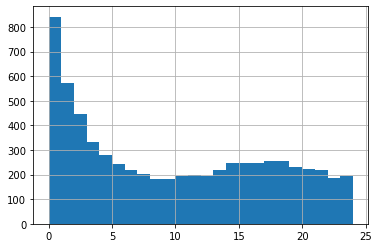

In [376]:
cleaned_df['first_loc_change_hours_since_admit'].hist(bins=24)

In [377]:
time_first_loc_change = cleaned_df.drop('first_loc_change_minutes_since_admit', axis=1)
time_first_loc_change.rename({'first_loc_change_hours_since_admit': 'hr_to_first_loc_change'}, inplace=True, axis=1)

print(time_first_loc_change.shape)
print(time_first_loc_change.pat_enc_csn_id_coded.nunique())
time_first_loc_change.head()

(6615, 2)
6615


,pat_enc_csn_id_coded,hr_to_first_loc_change
825439,131064103797,12.82
236137,131064484335,17.75
982386,131064522540,5.83
41475,131064558168,21.50
185158,131064616475,5.75


# Personel Count

Counting the number of personel on the treatment team prior to admit.

In [378]:
personel_file = "{}/cohort4_3hr_noOR_personel_2021.csv".format(datadir)
personel = pd.read_csv(personel_file)
print(personel.shape) #(202155, 5) #52165
print(personel.pat_enc_csn_id_coded.nunique())

# get distinct personel for each csn
distinct_personel = personel[['pat_enc_csn_id_coded', 'prov_map_id']].drop_duplicates()
print(distinct_personel.shape) # there were many dupliate personel #(196310, 2)

# count the number of distinct personel for each csn
personel_counts = distinct_personel.groupby(['pat_enc_csn_id_coded']).size().reset_index(name='personel_count')

(202155, 5)
52165
(196310, 2)


In [379]:
print(personel.dtypes)
print(personel.head(3))
personel_counts.head()

anon_id                            object
pat_enc_csn_id_coded                int64
name                               object
prov_map_id                        object
trtmnt_tm_begin_dt_jittered_utc    object
dtype: object
     anon_id  pat_enc_csn_id_coded                    name prov_map_id  \
0  JC2265054          131266988551                Resident   SS0203084   
1   JC565317          131254511542  Consulting Med Student   SS0291264   
2  JC3186972          131314515946                Resident   SS0329476   

  trtmnt_tm_begin_dt_jittered_utc  
0       2019-05-26 09:54:00+00:00  
1       2018-08-10 11:53:00+00:00  
2       2021-06-21 19:54:00+00:00  


,pat_enc_csn_id_coded,personel_count
0,131062572931,4
1,131062745090,7
2,131062927111,9
3,131063006922,4
4,131063022232,5


In [380]:
# personel_counts['pat_enc_csn_id_coded'] = personel_counts['pat_enc_csn_id_coded'].astype(int)
# print(personel_counts.dtypes)
# print(personel_counts.head(3))

### COMBINE them all
- (final_visits: for door-to-dispo time, first_ed_time)
- length_ed_ip: all time features -- includes `final_visits` already
- ip_emerg_traj: pat_loc (after admit) and pat_serv (before admit) +
- time_first_loc_change
- personel_counts: number of treatment team member before admission

In [381]:
print(length_ed_ip.columns)
print(ip_emerg_traj.columns)
print(time_first_loc_change.columns)
print(personel_counts.columns)

Index(['anon_id', 'pat_enc_csn_id_coded', 'admit_time', 'first_ed_time',
       'hours_in_ed', 'discharge_time', 'end_date', 'hours_ip_since_admit',
       'hours_ED_entry_end_date', 'died_before_discharge'],
      dtype='object')
Index(['anon_id', 'pat_enc_csn_id_coded', 'first_ip_lv_of_care',
       'first_ip_event_type', 'first_ip_pat_service', 'last_emerg_lv_of_care',
       'last_emerg_event_type', 'last_emerg_pat_service', 'pat_loc_traj',
       'pat_serv_traj'],
      dtype='object')
Index(['pat_enc_csn_id_coded', 'hr_to_first_loc_change'], dtype='object')
Index(['pat_enc_csn_id_coded', 'personel_count'], dtype='object')


In [382]:
# note if csn are int and float, don't merge! 
combined_df = length_ed_ip.merge(ip_emerg_traj, how='outer').merge(
                                    time_first_loc_change, how='outer').merge(personel_counts, how='outer')

print(combined_df.shape)
print(combined_df.pat_enc_csn_id_coded.nunique())

(52532, 20)
52532


In [383]:
savefile = outdir + "9_all_traj_time_team.csv"
combined_df.to_csv(savefile, index=False)

In [384]:
print(length_ed_ip.dtypes)
print(time_first_loc_change.dtypes)
personel_counts.dtypes

anon_id                                 object
pat_enc_csn_id_coded                     int64
admit_time                 datetime64[ns, UTC]
first_ed_time              datetime64[ns, UTC]
hours_in_ed                            float64
discharge_time             datetime64[ns, UTC]
end_date                                object
hours_ip_since_admit                   float64
hours_ED_entry_end_date                float64
died_before_discharge                   object
dtype: object
pat_enc_csn_id_coded        int64
hr_to_first_loc_change    float64
dtype: object


pat_enc_csn_id_coded    int64
personel_count          int64
dtype: object

In [385]:
combined_df.describe()

,pat_enc_csn_id_coded,hours_in_ed,hours_ip_since_admit,hours_ED_entry_end_date,hr_to_first_loc_change,personel_count
count,5.253200e+04,52532.000000,52385.000000,52385.000000,6615.000000,52165.000000
mean,1.312404e+11,4.810099,127.880118,134.768350,9.849492,3.763251
std,6.683841e+07,6.415100,3293.044890,3293.011544,7.546026,2.133207
min,1.310626e+11,0.020000,-750936.000000,-750912.000000,0.000000,1.000000
25%,1.312113e+11,2.300000,48.000000,48.000000,2.480000,2.000000
50%,1.312597e+11,3.500000,96.000000,96.000000,8.870000,3.000000
75%,1.312893e+11,5.250000,168.000000,168.000000,16.580000,5.000000
max,1.313209e+11,190.430000,5568.000000,5568.000000,24.000000,35.000000


In [386]:
neg = combined_df[combined_df.hours_ip_since_admit < 0]
neg.shape

(11, 20)

In [387]:
neg

,anon_id,pat_enc_csn_id_coded,admit_time,first_ed_time,hours_in_ed,discharge_time,end_date,hours_ip_since_admit,hours_ED_entry_end_date,died_before_discharge,first_ip_lv_of_care,first_ip_event_type,first_ip_pat_service,last_emerg_lv_of_care,last_emerg_event_type,last_emerg_pat_service,pat_loc_traj,pat_serv_traj,hr_to_first_loc_change,personel_count
21,JC1742795,131063593641,2015-01-07 01:17:00+00:00,2015-01-06 18:39:00+00:00,6.63,2015-01-07 12:45:00+00:00,2015-01-06,-24.0,0.0,True,Intermediate Care - With Cardiac Monitor,Transfer In,Pulmonary Hypertension,NaN,Transfer Out,Emergency,[Intermediate Care - With Cardiac Monitor],"[Emergency, Pulmonary Hypertension]",NaN,4.0
12361,JC1570903,131205648031,2016-11-21 00:58:00+00:00,2016-11-20 22:00:00+00:00,2.97,2016-12-04 01:15:00+00:00,2013-07-12,-29472.0,-29448.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,Bone Marrow Transplant,NaN,Admission,Emergency,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Bone Marrow Transplant]",NaN,4.0
12565,JC1003846,131207384171,2016-11-12 21:25:00+00:00,2016-11-12 18:59:00+00:00,2.43,2016-11-19 00:18:00+00:00,2015-11-23,-8520.0,-8520.0,True,Intermediate Care - With Cardiac Monitor,Patient Update,Oncology,NaN,Admission,Emergency,[Intermediate Care - With Cardiac Monitor],"[Emergency, Oncology]",NaN,4.0
12681,JC1570903,131208290278,2016-12-10 04:41:00+00:00,2016-12-10 03:56:00+00:00,0.75,2017-01-02 19:10:00+00:00,2013-07-12,-29928.0,-29928.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,Oncology,NaN,Admission,Emergency,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Oncology]",NaN,5.0
13706,JC1887289,131214792161,2017-02-10 02:45:00+00:00,2017-02-10 01:38:00+00:00,1.12,2017-02-24 18:00:00+00:00,2016-03-06,-8184.0,-8184.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,Bone Marrow Transplant,NaN,Admission,Emergency,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Bone Marrow Transplant]",NaN,2.0
30870,JC519415,131267837304,2019-06-09 06:06:00+00:00,2019-06-08 21:23:00+00:00,8.72,2019-06-11 21:13:00+00:00,1933-10-09,-750936.0,-750912.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,General Medicine (University),NaN,Admission,Emergency,[Acute Care (Assessment or intervention q4-8)],"[Emergency, General Medicine (University)]",NaN,4.0
36535,JC1535589,131281935238,2020-01-28 00:26:00+00:00,2020-01-27 19:35:00+00:00,4.85,2020-01-30 03:32:00+00:00,2020-01-19,-216.0,-192.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,General Medicine (University),NaN,Patient Update,Emergency Medicine,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Emergency Medicine, General Medici...",NaN,2.0
36723,JC2725200,131282296021,2020-01-17 21:26:00+00:00,2020-01-17 18:46:00+00:00,2.67,2020-01-23 02:51:00+00:00,2019-12-31,-408.0,-408.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,Oncology,NaN,Patient Update,Emergency Medicine,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Emergency Medicine, Oncology]",NaN,3.0
40588,JC2725200,131291646406,2020-07-12 22:33:00+00:00,2020-07-12 16:56:00+00:00,5.62,2020-07-14 22:48:00+00:00,2019-12-31,-4656.0,-4656.0,True,Acute Care (Assessment or intervention q4-8),Patient Update,Gastroenterology,NaN,Patient Update,Emergency Medicine,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Emergency Medicine, Gastroenterology]",NaN,3.0
45192,JC1403434,131301986402,2021-01-04 20:38:00+00:00,2021-01-04 19:07:00+00:00,1.52,2021-01-14 22:30:00+00:00,2021-01-01,-72.0,-72.0,True,Critical Care,Patient Update,Critical Care,NaN,Patient Update,Emergency Medicine,[Critical Care],"[Emergency, Emergency Medicine, Critical Care]",NaN,4.0


In [388]:
combined_df.head(3)

,anon_id,pat_enc_csn_id_coded,admit_time,first_ed_time,hours_in_ed,discharge_time,end_date,hours_ip_since_admit,hours_ED_entry_end_date,died_before_discharge,first_ip_lv_of_care,first_ip_event_type,first_ip_pat_service,last_emerg_lv_of_care,last_emerg_event_type,last_emerg_pat_service,pat_loc_traj,pat_serv_traj,hr_to_first_loc_change,personel_count
0,JC1170548,131062572931,2015-01-02 03:48:00+00:00,2015-01-01 18:40:00+00:00,9.13,2015-01-03 21:52:00+00:00,2015-01-03,24.0,48.0,NaN,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (University),NaN,Transfer Out,Emergency,[Intermediate Care - With Cardiac Monitor],"[Emergency, General Medicine (University)]",NaN,4.0
1,JC913990,131062745090,2015-01-02 05:53:00+00:00,2015-01-02 01:56:00+00:00,3.95,2015-01-06 02:00:00+00:00,2015-01-06,96.0,96.0,NaN,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,NaN,Transfer Out,Emergency,[Acute Care (Assessment or intervention q4-8)],"[Emergency, Orthopaedic Surgery]",NaN,7.0
2,JC529112,131062927111,2015-01-05 03:20:00+00:00,2015-01-04 18:13:00+00:00,9.12,2015-01-09 00:22:00+00:00,2015-01-09,96.0,120.0,NaN,Critical Care,Transfer In,Critical Care,NaN,Transfer Out,Emergency,[Critical Care],"[Emergency, Critical Care]",NaN,9.0
